In [46]:
%matplotlib inline  
import feather
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pgmpy
from pgmpy.estimators import HillClimbSearch, BicScore
from tqdm import tqdm
import warnings

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [2]:
%%time
pandas_df = feather.read_dataframe('data/sample_feather')

CPU times: user 297 ms, sys: 1.67 s, total: 1.97 s
Wall time: 1.03 s


# Discretizing the Response Variables

For the Type of data we will be using here, all the variables are required to be Discrete. Thus we need to Discretize all grade variables from students

In [3]:
grades = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT', 'NU_NOTA_REDACAO']

In [4]:
before = pandas_df[grades].head()

In [5]:
pandas_df['NU_NOTA_CN'] = pd.cut(pandas_df['NU_NOTA_CN'], bins=[0,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])
pandas_df['NU_NOTA_CH'] = pd.cut(pandas_df['NU_NOTA_CH'], bins=[0,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])
pandas_df['NU_NOTA_LC'] = pd.cut(pandas_df['NU_NOTA_LC'], bins=[0,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])
pandas_df['NU_NOTA_MT'] = pd.cut(pandas_df['NU_NOTA_MT'], bins=[0,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])
pandas_df['NU_NOTA_REDACAO'] = pd.cut(pandas_df['NU_NOTA_REDACAO'], bins=[0,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])

In [6]:
len(pandas_df)

442675

In [72]:
before

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,465.1,560.4,537.6,522.2,580.0
1,638.9,642.9,622.2,658.8,920.0
2,569.6,566.4,575.1,605.3,640.0
3,570.1,572.5,601.7,701.6,620.0
4,508.9,436.5,489.1,602.8,600.0


In [73]:
pandas_df[grades].head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,baixa,media,media,media,media
1,media,media,media,alta,muito alta
2,media,media,media,media,media
3,media,media,media,alta,media
4,media,baixa,baixa,media,media


In [9]:
pandas_df.head()

,CO_MUNICIPIO_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,CO_MUNICIPIO_PROVA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,3550308.0,21.0,F,1.0,3.0,1.0,3550308.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3550308.0,baixa,media,media,media,0.0,1.0,media,B,D,B,B,3.0,F,A,B,B,A,A,B,A,B,A,B,A,B,C,B,A,C,B,C,B,A,A
1,3133808.0,28.0,F,NaN,1.0,1.0,3133808.0,1.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3133808.0,media,media,media,alta,0.0,1.0,muito alta,C,D,C,B,2.0,H,A,C,D,A,B,B,B,A,A,B,A,A,C,A,A,C,A,B,B,A,A
2,3304557.0,17.0,F,0.0,3.0,1.0,3304557.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3304557.0,media,media,media,media,0.0,1.0,media,F,G,E,E,2.0,O,A,C,C,B,A,B,A,B,A,B,A,A,D,B,B,C,B,C,B,C,D
3,2310902.0,24.0,M,0.0,2.0,1.0,2310902.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2308500.0,media,media,media,alta,1.0,1.0,media,B,B,A,A,5.0,B,A,B,D,A,B,B,A,A,A,B,A,A,C,B,A,D,A,B,B,A,A
4,2503209.0,18.0,F,1.0,3.0,1.0,2507507.0,2.0,0.0,2.0,1.0,0.0,25091611.0,2503209.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2503209.0,media,baixa,baixa,media,1.0,1.0,media,C,E,A,B,3.0,B,A,B,D,A,B,B,A,B,A,A,A,A,B,A,A,B,A,B,B,B,A


In [16]:
grades+['Q00{}'.format(i) for i in range(1,3)]

['NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'NU_NOTA_MT',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002']

# Structure Learning
## Some simple tests

In [9]:
# create data sample with 9 random variables:
data = pd.DataFrame(np.random.randint(0, 5, size=(500000, 9)), columns=list('ABCDEFGHI'))
# add 10th dependent variable
data['J'] = data['A'] * data['B']
est = HillClimbSearch(data, scoring_method=BicScore(data))

In [10]:
%%time
best_model = est.estimate()
sorted(best_model.nodes())

CPU times: user 9min 3s, sys: 2min 9s, total: 11min 12s
Wall time: 5min 44s


/home/abarbosa/miniconda3/envs/pgm/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: Could not load "/home/abarbosa/miniconda3/envs/pgm/lib/graphviz/libgvplugin_pango.so.6" - file not found

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


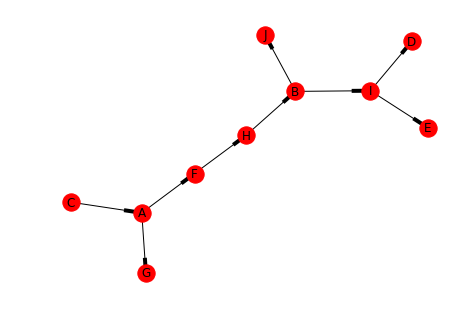

In [13]:
nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
plt.show();

In [78]:
est = HillClimbSearch(pandas_df[grades+['Q00{}'.format(i) for i in range(1,10)]],
                      scoring_method=BicScore(pandas_df[grades+['Q00{}'.format(i) for i in range(1,10)]]))

In [79]:
%%time
best_model = est.estimate()

CPU times: user 46min 43s, sys: 48.7 s, total: 47min 31s
Wall time: 24min 35s


In [31]:
len(set(pandas_df['CO_MUNICIPIO_RESIDENCIA']))

5534

In [38]:
len(set(pandas_df['NU_IDADE']))

82

In [ ]:
est = HillClimbSearch(pandas_df[grades+['Q00{}'.format(i) for i in range(1,10)]+['Q0{}'.format(i) for i in range(11,28)]],
                      scoring_method=BicScore(pandas_df[grades+['Q00{}'.format(i) for i in range(1,10)]+['Q0{}'.format(i) for i in range(11,28)]]))

In [ ]:
%%time
best_model_2 = est.estimate()

5 variáveis - 26s

6 variáveis - 51s (~25s)

7 variáveis - 100s (~50s)

8 variáveis (Considerando a Idade) - 180s (~80s)

9 variáveis (Considerando a Idade)- 288s (~100s)

10 variáveis (Considerando a Idade) - 480s(~200s)

11 variáveis (Sem considerar a Idade) - 720s (~240)

4 variáveis (Código de Residência) - 520s

Aparentemente, isso depende da quantidade de variáveis categóricas disponíveis. Como os códigos de residências são combinações muito grandes de variáveis, isso explode o espaço de buscas.

In [80]:
len(sorted(best_model.nodes()))

14

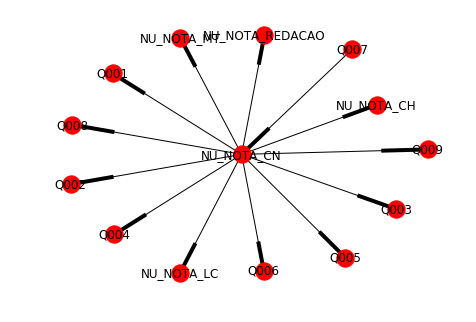

In [81]:
nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
plt.show();